In [1]:
from k_means_constrained import KMeansConstrained
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import rpy2
import rpy2.robjects as ro
import os
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
import time
import random
import time
from numpy.random import seed
from scipy.stats import f

In [2]:
random.seed(time.time())
seed(int(time.time()))

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/thistleknot/Python-Stock/master/data/raw/states.csv")

x_std = StandardScaler().fit_transform(df.iloc[:,1:])

pca = PCA(svd_solver='full')
pca.fit(x_std)
pca.explained_variance_
print(pca.explained_variance_ratio_.cumsum())

#pca = PCA(n_components=1)
#pca.fit(X)
X_pca = pd.DataFrame(pca.transform(x_std))

[0.4300452  0.64027541 0.75615596 0.82679405 0.88494424 0.92799797
 0.96156524 0.98000444 0.99484731 1.        ]


In [4]:
def findknee(xdata):
    rate_of_change=(xdata[0]-xdata[-1])/(len(xdata)-1)
    #print(rate_of_change)
    delta = xdata-xdata[-1]
    deltas = []
    deltas.append(delta[0])
    for d in range(1,len(xdata)):
        deltas.append(deltas[d-1]-rate_of_change)
    #print(deltas)
    for d in range(0,len(xdata)):
        deltas[d]=delta[d]-deltas[d]
    return(np.round(np.abs(deltas)))


In [5]:
mink = 3
maxk = 15

In [6]:
init_min = 2
init_max = 5

In [7]:
def deriveANOVA(clf, df):

    labels = clf.labels_
    clusters = clf.n_clusters
    centers = clf.cluster_centers_
        
    within_ss = []

    for n in range(0,clusters):
      #WSS means the sum of distances between the points and the corresponding centroids for each cluster
      data = df[labels==(n)]
      within_ss.append(((data - centers[n])**2).sum(1).sum())

    WSS = total_within_ss = np.sum(within_ss)

    print('wss',total_within_ss)

    #sum of ((deviation from variable means) squared)
    tot_ss = np.sum(np.sum((df-df.mean())**2))
    print('tot_ss',tot_ss)

    cluster_BSS = []
    for n in range(0,clusters):
      #sum((variable/column means cluster - variable/column means data)^2)*len(cluster members)
      BSS = np.sum((df[labels==(n)].mean()-np.array(np.mean(df)))**2)*len(df[labels==(n)])
      cluster_BSS.append(BSS)

    BSS = np.sum(cluster_BSS)
    print('bss',BSS)
    
    return(tot_ss, BSS, within_ss)

def findOptimalK_ANOVA(df, mink=3, maxk=15, init_min=2, init_max=5):

    tss = []
    bss = []
    wss = []

    for k in range(mink,maxk):
        print(k)

        clf = KMeansConstrained(n_clusters=k, size_min=init_min, size_max=max(np.ceil(len(df)/k),init_max), init='k-means++', n_init=100, max_iter=100, tol=0.0001, verbose=False, random_state=None, copy_x=True, n_jobs=4)
        clf.fit_predict(np.array(df))

        tot_ss, BSS, within_ss = deriveANOVA(clf, df)
       
        wss.append(within_ss)
        tss.append(tot_ss)
        bss.append(BSS)

    return(tss, bss, wss)
    

In [8]:
tss, bss, wss = findOptimalK_ANOVA(X_pca)

3
wss 295.33541317305645
tot_ss 500.00000000000006
bss 204.6645868269436
4
wss 245.29889619365105
tot_ss 500.00000000000006
bss 254.7011038063491
5
wss 231.80753075697675
tot_ss 500.00000000000006
bss 268.1924692430233
6
wss 200.15853753701026
tot_ss 500.00000000000006
bss 299.8414624629898
7
wss 186.7875232985095
tot_ss 500.00000000000006
bss 313.2124767014906
8
wss 171.9166763698156
tot_ss 500.00000000000006
bss 328.08332363018457
9
wss 161.1570544501567
tot_ss 500.00000000000006
bss 338.8429455498434
10
wss 158.4622626120873
tot_ss 500.00000000000006
bss 341.5377373879128
11
wss 143.324547683454
tot_ss 500.00000000000006
bss 356.67545231654606
12
wss 131.4983010746918
tot_ss 500.00000000000006
bss 368.50169892530835
13
wss 123.91356506793547
tot_ss 500.00000000000006
bss 376.0864349320646
14
wss 115.88086086487225
tot_ss 500.00000000000006
bss 384.11913913512785


6


C:\Users\User\AppData\Local\Temp/ipykernel_10152/407223187.py:7: RuntimeWarning: invalid value encountered in true_divide
  temp_df = pd.DataFrame(bss_/wss_).replace([np.inf, -np.inf, np.NaN], 0)


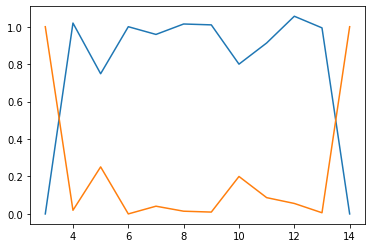

In [9]:
bss_ = findknee(bss)
bss_ = bss_/np.max(bss_)

wss_ = findknee(np.array(pd.DataFrame(wss).mean(1)))
wss_ = wss_/np.max(wss_)

temp_df = pd.DataFrame(bss_/wss_).replace([np.inf, -np.inf, np.NaN], 0)
temp_df.index = np.array(range(0,len(wss_)))+mink
plt.plot(temp_df)

set_ = np.abs(temp_df-1)
plt.plot(set_)
#plt.plot(set_)
optimal_k = np.nanargmin(set_)+mink

print(optimal_k)

In [10]:
clf = KMeansConstrained(n_clusters=optimal_k, size_min=init_min, size_max=max(np.ceil(len(df)/optimal_k),init_max), init='k-means++', n_init=100, max_iter=100, tol=0.0001, verbose=False, random_state=None, copy_x=True, n_jobs=4)
clf.fit_predict(X_pca)

labels = clf.labels_
clusters = clf.n_clusters
centers = clf.cluster_centers_

tot_ss, BSS, within_ss = deriveANOVA(clf, X_pca)


wss 200.1585375370103
tot_ss 500.00000000000006
bss 299.8414624629898


F-Scores: [ 78.52330489  66.43137145  60.12298189 152.1336309   81.82322516
  79.09952175]
P-Scores: [1.11022302e-16 1.11022302e-16 1.11022302e-16 1.11022302e-16
 1.11022302e-16 1.11022302e-16]


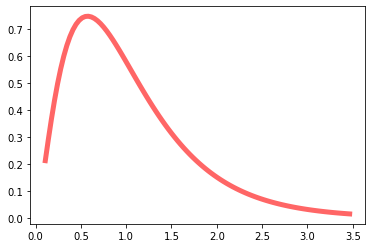

In [11]:
dfn = (optimal_k-1)
dfd = len(df)-(optimal_k)

F_scores = (BSS/dfn)/(within_ss/(dfd))

x = np.linspace(f.ppf(0.01, dfn, dfd),
                f.ppf(0.99, dfn, dfd), 100)
plt.plot(x, f.pdf(x, dfn, dfd),
       'r-', lw=5, alpha=0.6, label='f pdf')

print("F-Scores:", F_scores)

print("P-Scores:", 1-f.cdf(F_scores, dfn, dfd))

In [12]:
df['cluster'] = labels

In [13]:
wd = os.getcwd()

if (os.defpath==".;C:\\bin"):
    os.environ['R_HOME'] = 'C:/Users/User/Documents/R/R-4.1.2'
    os.environ['R_LIBS'] = 'C:/Users/User/Documents/R/R-4.1.2/library'
    from OLS_LR_DiagnosticPlots.ModelDiagnostics import Plot
else:
    os.environ['R_HOME'] = '/mnt/distvol/R/4.0.5/lib64/R/'

pandas2ri.activate()

base = importr('base')
grdevices = importr('grDevices')
print(base._libPaths())

#urbnmapr = importr('urbnmapr')
dplyr = importr('dplyr')
tidyverse = importr('tidyverse')

with localconverter(ro.default_converter + pandas2ri.converter):
      r_from_pd_df = ro.conversion.py2rpy(df)


[1] "C:/Users/User/Documents/R/R-4.1.2/library"



In [14]:
ro.r('''

f <- function(df) {
library(urbnmapr)
library(viridis)
library(hrbrthemes)
library(dplyr)
#print(df)
spatial_data <- left_join(get_urbn_map(map = "states", sf = TRUE),
                          statedata,
                          by = "state_name")

spatial_data <- spatial_data[spatial_data$state_name %in% df$States,] %>% left_join(df, by = c('state_name' = 'States'))
spatial_data$cluster <- factor(spatial_data$cluster)

print(paste("C:\\\\Users\\\\User\\\\Documents\\\\wiki\\\\wiki\\\\dev\\\\R\\\\","clusterMap",sep = "",".png"),width = 1200, height = 800, units = "px", pointsize = 12, quality = 90)
jpeg(paste("C:\\\\Users\\\\User\\\\Documents\\\\wiki\\\\wiki\\\\dev\\\\R\\\\","clusterMap",sep = "",".png"),width = 1200, height = 800, units = "px", pointsize = 12, quality = 90)

p <- ggplot() +
  geom_sf(spatial_data,
          mapping = aes(fill = cluster),
          color = "#ffffff", size = 0.25) + scale_fill_discrete() +
  geom_sf_text(data = get_urbn_labels(map = "states", sf = TRUE), 
               aes(label = state_abbv), 
               size = 3)
  labs(fill = "cluster")

plot(p)
dev.off() 

sample_size = df %>% group_by(cluster) %>% summarize(num=n())  

# sample size
  
for (c in colnames(df)[2:(length(colnames(df))-1)])
{
  print(c)
  colnames(sample_size) <- c("name","num")
  
  data <- as_data_frame(cbind(df[,c("cluster"),drop=FALSE],df[,c,drop=FALSE]))
  colnames(data) <- c("name","value")
  
  jpeg(paste("C:\\\\Users\\\\User\\\\Documents\\\\wiki\\\\wiki\\\\dev\\\\R\\\\","clusterMap-",c,sep = "",".png"),width = 1200, height = 800, units = "px", pointsize = 12, quality = 90)
  # Plot
  plot(
  data %>%
    left_join(sample_size) %>%
    mutate(myaxis = paste0(name, "\n", "n=", num)) %>%
    ggplot( aes(x=myaxis, y=value, fill=name)) +
    geom_violin(width=1.4) +
    geom_boxplot(width=0.1, color="grey", alpha=0.2) +
    scale_fill_viridis(discrete = FALSE) +
    theme_ipsum() +
    theme(
      legend.position="none",
      plot.title = element_text(size=16)
    ) +
    ggtitle(c) #+
    #xlab("")  + ylab(c)
  )
  dev.off()
}
#print(df)
#return(df)
}

''')

r_f = ro.globalenv['f']
d=(r_f(r_from_pd_df))


R[write to console]: Loading required package: viridisLite

R[write to console]: old-style crs object detected; please recreate object with a recent sf::st_crs()



[1] "C:\\Users\\User\\Documents\\wiki\\wiki\\dev\\R\\clusterMap.png"


R[write to console]: old-style crs object detected; please recreate object with a recent sf::st_crs()



[1] "Poverty"
Joining, by = "name"
[1] "Infant Mort"
Joining, by = "name"
[1] "White"
Joining, by = "name"
[1] "Crime"
Joining, by = "name"
[1] "Doctors"
Joining, by = "name"
[1] "Traf Deaths"
Joining, by = "name"
[1] "University"
Joining, by = "name"
[1] "Unemployed"
Joining, by = "name"
[1] "Income"
Joining, by = "name"
[1] "Population"
Joining, by = "name"
